In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
ff_pts = pd.read_csv('../data/processed/modeling-data.csv')
# Drop non-adjusted columns
ff_pts.drop(columns = ff_pts.loc[:, 'passing_cmp':'fantasy_ppr'].columns, inplace = True)

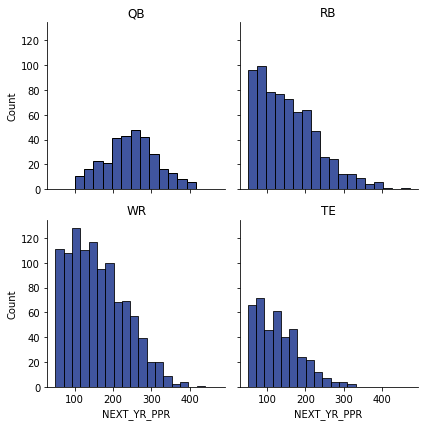

In [3]:
# Distribution of response variable by position
sns.set_palette('dark')
g = sns.FacetGrid(data = ff_pts, col = 'fantpos', col_wrap = 2, col_order = ['QB', 'RB', 'WR', 'TE'])
ax = g.map(sns.histplot, 'NEXT_YR_PPR')
axes = g.axes.flatten()
axes[0].set_title('QB')
axes[1].set_title('RB')
axes[2].set_title('WR')
axes[3].set_title('TE')
plt.show()

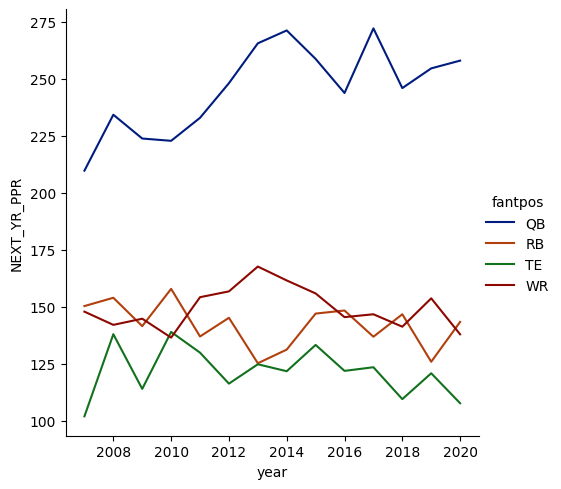

In [4]:
# Change of response variable over time by position
pos_yr_pts = ff_pts.groupby(['fantpos', 'year']).median().loc[:, 'NEXT_YR_PPR'].reset_index()
sns.relplot(data = pos_yr_pts, x = 'year', y = 'NEXT_YR_PPR', hue = 'fantpos', kind = 'line')
plt.show()

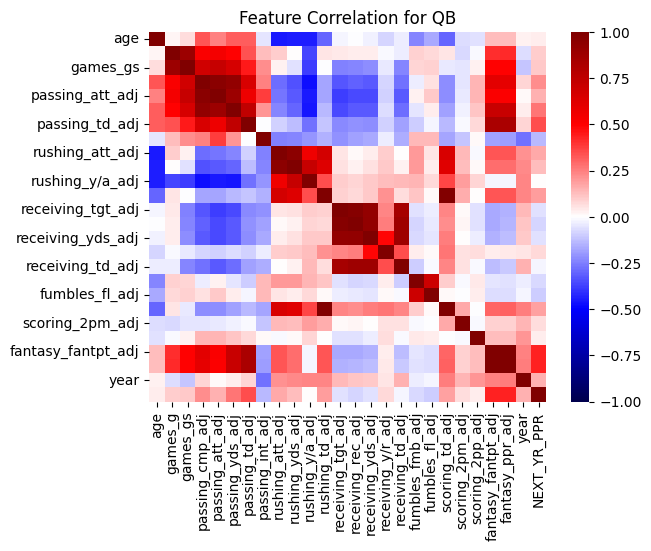

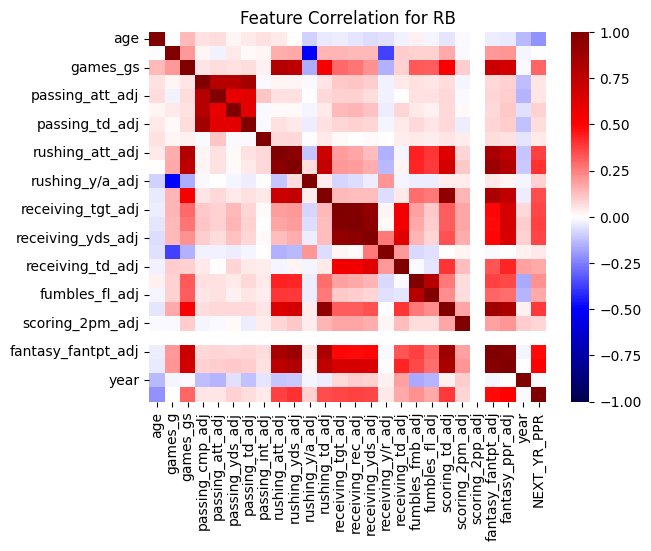

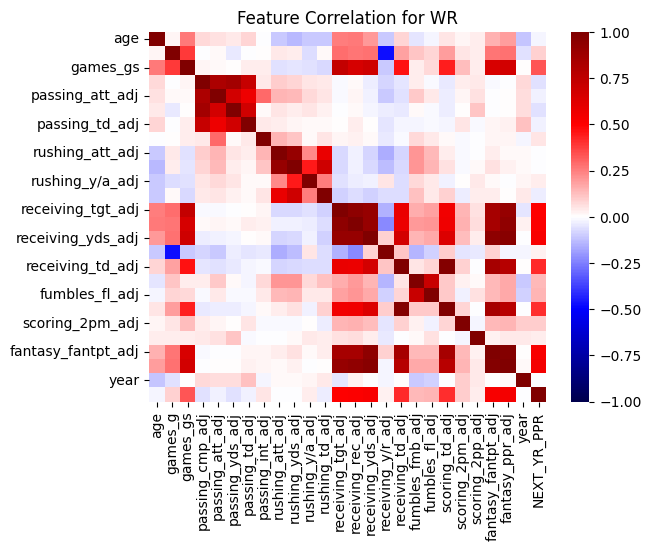

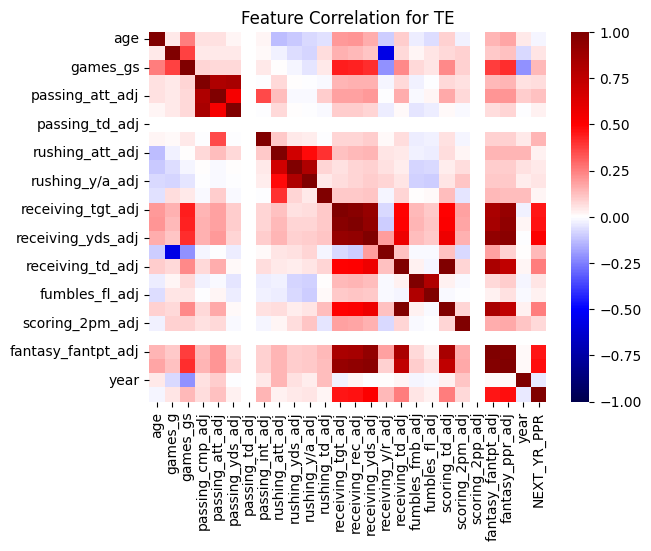

In [5]:
for pos in ['QB', 'RB', 'WR', 'TE']: # Manually specify order
    pos_data = ff_pts[ff_pts.fantpos == pos].corr()
    ax = sns.heatmap(data = pos_data, cmap = 'seismic', vmin = -1, vmax = 1, center = 0)
    plt.title('Feature Correlation for ' + pos)
    plt.show()

In [6]:
pos_corrs = ff_pts.groupby('fantpos').corr().reset_index()
pos_corrs = pos_corrs.melt(id_vars = ['fantpos', 'level_1']).rename(columns = {'level_1': 'var1', 'variable': 'var2'})
pos_corrs[(pos_corrs.var1 != pos_corrs.var2) & (abs(pos_corrs.value) > 0.75)].\
    sort_values('value', ascending = False).reset_index(drop = True)

,fantpos,var1,var2,value
0,QB,fantasy_ppr_adj,fantasy_fantpt_adj,0.999775
1,QB,fantasy_fantpt_adj,fantasy_ppr_adj,0.999775
2,TE,receiving_td_adj,scoring_td_adj,0.998545
3,TE,scoring_td_adj,receiving_td_adj,0.998545
4,QB,scoring_td_adj,rushing_td_adj,0.984845
...,...,...,...,...
133,WR,scoring_td_adj,fantasy_ppr_adj,0.777126
134,RB,rushing_att_adj,fantasy_ppr_adj,0.764781
135,RB,fantasy_ppr_adj,rushing_att_adj,0.764781
136,RB,games_gs,rushing_yds_adj,0.762840


From the above correlation plots, we see that multicollinearity appears to be a distinct issue, so feature transformation will be necessary. Some of the features--such as scoring touchdowns or yards per attempt--are aggregate columns, indicating the can be calculated deterministically by using other columns. Therefore, selecting a subset of the columns is relevant prior to any model building.

Some variables we will remove are:
- `games_gs`: Games started
- `rushing_y/a_adj`: Rushing yards per attempt
- `receiving_y/r_adj`: Receiving yards per reception
- Total number of fantasy points scored last year (these are deterministic combinations of other features present)
    - `fantasy_fantpt_adj`: Adjusted fantasy points scored, non-PPR
    - `fantasy_ppr_adj`: Adjusted fantasy points scored, PPR

In [7]:
ff_pts.drop(columns = ['games_gs', 'rushing_y/a_adj', 'receiving_y/r_adj', 'fantasy_fantpt_adj', 'fantasy_ppr_adj'], inplace = True)
ff_pts.to_csv('../data/processed/modeling-data-reduced.csv', index = False)